# Strategies for Dynamic DEM Data Download and Use
David Shean  
February 19, 2021

Work in progress, several attempts to load larger files on hub failed, but dynamic access should work.  Need a better way to prepare the 1-m 3DEP tiles.

In [40]:
import os
import s3fs
import rasterio as rio
from rasterio import plot, mask
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
wa_bounds = (-124.733174, 45.543541, -116.915989, 49.002494)

## Use OpenTopography GlobalDEM API to fetch DEM for WA state
* OpenTopgraphy is a fantastic organization that "facilitates community access to high-resolution, Earth science-oriented, topography data, and related tools and resources."
    * https://opentopography.org/about
* One of the many services they provide is an API for several popular Global DEM datasets, with simple subsetting and delivery: https://opentopography.org/developers
* We'll use this service to extract a small portion of the SRTM-GL3 DEM

In [3]:
#List of all products hosted by OpenTopography GlobalDEM API
demtype_list = ["SRTMGL3", "SRTMGL1", "SRTMGL1_E", "AW3D30", "AW3D30_E", "SRTM15Plus"]

In [4]:
demtype = demtype_list[0]
demtype

'SRTMGL3'

In [5]:
base_url="https://portal.opentopography.org/API/globaldem?demtype={}&west={}&south={}&east={}&north={}&outputFormat=GTiff"

In [6]:
base_url.format(demtype, *wa_bounds)

'https://portal.opentopography.org/API/globaldem?demtype=SRTMGL3&west=-124.733174&south=45.543541&east=-116.915989&north=49.002494&outputFormat=GTiff'

In [7]:
def get_OT_GlobalDEM(demtype, bounds, out_fn=None):
    if out_fn is None:
        out_fn = '{}.tif'.format(demtype)
    
    if not os.path.exists(out_fn):
        #Prepare API request url
        #Bounds should be [minlon, minlat, maxlon, maxlat]
        url = base_url.format(demtype, *bounds)
        print(url)
        #Get
        response = requests.get(url)
        #Should check for 200
        #Write to disk
        open(out_fn, 'wb').write(response.content)

In [8]:
out_fn = f"WA_{demtype}.tif"
out_fn

'WA_SRTMGL3.tif'

In [9]:
get_OT_GlobalDEM(demtype, wa_bounds, out_fn)

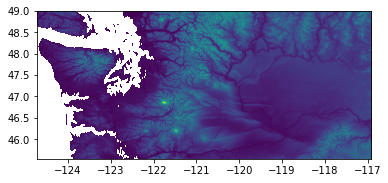

In [10]:
with rio.open(out_fn) as src:
    rio.plot.show(src)

## Copernicus DEM from AWS

In [11]:
dst_crs = 'EPSG:32610'

In [12]:
s3 = s3fs.S3FileSystem(anon=True)

In [13]:
bucket = 'copernicus-dem-30m'
bucket = 'copernicus-dem-90m'

In [11]:
s3.ls(bucket)

['copernicus-dem-30m/Copernicus_DSM_COG_10_N00_00_E006_00_DEM',
 'copernicus-dem-30m/Copernicus_DSM_COG_10_N00_00_E009_00_DEM',
 'copernicus-dem-30m/Copernicus_DSM_COG_10_N00_00_E010_00_DEM',
 'copernicus-dem-30m/Copernicus_DSM_COG_10_N00_00_E011_00_DEM',
 'copernicus-dem-30m/Copernicus_DSM_COG_10_N00_00_E012_00_DEM',
 'copernicus-dem-30m/Copernicus_DSM_COG_10_N00_00_E013_00_DEM',
 'copernicus-dem-30m/Copernicus_DSM_COG_10_N00_00_E014_00_DEM',
 'copernicus-dem-30m/Copernicus_DSM_COG_10_N00_00_E015_00_DEM',
 'copernicus-dem-30m/Copernicus_DSM_COG_10_N00_00_E016_00_DEM',
 'copernicus-dem-30m/Copernicus_DSM_COG_10_N00_00_E017_00_DEM',
 'copernicus-dem-30m/Copernicus_DSM_COG_10_N00_00_E018_00_DEM',
 'copernicus-dem-30m/Copernicus_DSM_COG_10_N00_00_E019_00_DEM',
 'copernicus-dem-30m/Copernicus_DSM_COG_10_N00_00_E020_00_DEM',
 'copernicus-dem-30m/Copernicus_DSM_COG_10_N00_00_E021_00_DEM',
 'copernicus-dem-30m/Copernicus_DSM_COG_10_N00_00_E022_00_DEM',
 'copernicus-dem-30m/Copernicus_DSM_COG_

In [14]:
#Get the grid polygon definitions for tiles
grid_fn = 'grid.zip'

In [10]:
#Should be able to load grid directly from S3 bucket to geopandas
#Need to create AWS session
#https://fiona.readthedocs.io/en/latest/manual.html#cloud-storage-credentials
#gpd.read_file('zip+s3://{}/{}'.format(bucket, grid_fn))

In [15]:
s3.get_file(f"{bucket}/{grid_fn}", grid_fn)

In [18]:
#Read directly from zip
grid = gpd.read_file('zip://{}'.format(grid_fn))

In [17]:
grid.head()

,id,geometry
0,Copernicus_DSM_COG_30_N85_00_W180_00_DEM,"POLYGON ((-180.004 85.000, -180.004 86.000, -1..."
1,Copernicus_DSM_COG_30_N85_00_W179_00_DEM,"POLYGON ((-179.004 85.000, -179.004 86.000, -1..."
2,Copernicus_DSM_COG_30_N85_00_W178_00_DEM,"POLYGON ((-178.004 85.000, -178.004 86.000, -1..."
3,Copernicus_DSM_COG_30_N85_00_W177_00_DEM,"POLYGON ((-177.004 85.000, -177.004 86.000, -1..."
4,Copernicus_DSM_COG_30_N85_00_W176_00_DEM,"POLYGON ((-176.004 85.000, -176.004 86.000, -1..."


In [19]:
grid.shape

(64800, 2)

## Use polygon for query and download necessary tiles

In [21]:
#Read in arbitrary polygon
#poly_gdf = gpd.read_file(poly_fn)

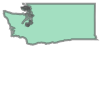

In [22]:
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)
wa_state_gdf = states_gdf.loc[states_gdf['NAME'] == 'Washington']
wa_geom = wa_state_gdf.iloc[0].geometry
wa_geom

In [23]:
idx = grid.intersects(wa_geom)

In [24]:
fn_list = grid[idx]['id'].values
fn_list

array(['Copernicus_DSM_COG_30_N45_00_W123_00_DEM',
       'Copernicus_DSM_COG_30_N45_00_W122_00_DEM',
       'Copernicus_DSM_COG_30_N45_00_W121_00_DEM',
       'Copernicus_DSM_COG_30_N45_00_W120_00_DEM',
       'Copernicus_DSM_COG_30_N45_00_W119_00_DEM',
       'Copernicus_DSM_COG_30_N45_00_W118_00_DEM',
       'Copernicus_DSM_COG_30_N45_00_W117_00_DEM',
       'Copernicus_DSM_COG_30_N46_00_W125_00_DEM',
       'Copernicus_DSM_COG_30_N46_00_W124_00_DEM',
       'Copernicus_DSM_COG_30_N46_00_W123_00_DEM',
       'Copernicus_DSM_COG_30_N46_00_W122_00_DEM',
       'Copernicus_DSM_COG_30_N46_00_W121_00_DEM',
       'Copernicus_DSM_COG_30_N46_00_W120_00_DEM',
       'Copernicus_DSM_COG_30_N46_00_W119_00_DEM',
       'Copernicus_DSM_COG_30_N46_00_W118_00_DEM',
       'Copernicus_DSM_COG_30_N46_00_W117_00_DEM',
       'Copernicus_DSM_COG_30_N47_00_W125_00_DEM',
       'Copernicus_DSM_COG_30_N47_00_W124_00_DEM',
       'Copernicus_DSM_COG_30_N47_00_W123_00_DEM',
       'Copernicus_DSM_COG_30_N

In [26]:
#List first filename as check
s3.ls('{}/{}'.format(bucket, fn_list[0]))

['copernicus-dem-90m/Copernicus_DSM_COG_30_N45_00_W123_00_DEM/Copernicus_DSM_COG_30_N45_00_W123_00_DEM.tif']

In [27]:
outdir = 'Copernicus_DEM_3arcsec'
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [27]:
for fn in fn_list:
    print(fn)
    s3.get_file(f"{bucket}/{fn}/{fn}.tif", os.path.join(outdir, f"{fn}.tif"))

Copernicus_DSM_COG_30_N45_00_W123_00_DEM
Copernicus_DSM_COG_30_N45_00_W122_00_DEM
Copernicus_DSM_COG_30_N45_00_W121_00_DEM
Copernicus_DSM_COG_30_N45_00_W120_00_DEM
Copernicus_DSM_COG_30_N45_00_W119_00_DEM
Copernicus_DSM_COG_30_N45_00_W118_00_DEM
Copernicus_DSM_COG_30_N45_00_W117_00_DEM
Copernicus_DSM_COG_30_N46_00_W125_00_DEM
Copernicus_DSM_COG_30_N46_00_W124_00_DEM
Copernicus_DSM_COG_30_N46_00_W123_00_DEM
Copernicus_DSM_COG_30_N46_00_W122_00_DEM
Copernicus_DSM_COG_30_N46_00_W121_00_DEM
Copernicus_DSM_COG_30_N46_00_W120_00_DEM
Copernicus_DSM_COG_30_N46_00_W119_00_DEM
Copernicus_DSM_COG_30_N46_00_W118_00_DEM
Copernicus_DSM_COG_30_N46_00_W117_00_DEM
Copernicus_DSM_COG_30_N47_00_W125_00_DEM
Copernicus_DSM_COG_30_N47_00_W124_00_DEM
Copernicus_DSM_COG_30_N47_00_W123_00_DEM
Copernicus_DSM_COG_30_N47_00_W122_00_DEM
Copernicus_DSM_COG_30_N47_00_W121_00_DEM
Copernicus_DSM_COG_30_N47_00_W120_00_DEM
Copernicus_DSM_COG_30_N47_00_W119_00_DEM
Copernicus_DSM_COG_30_N47_00_W118_00_DEM
Copernicus_DSM_C

In [29]:
!ls -lah $outdir

total 180M
drwxr-sr-x 3 jovyan users 4.0K Feb 17 03:33 .
drwxrwsr-x 4 jovyan users 4.0K Feb 17 03:32 ..
drwxr-sr-x 2 jovyan users 4.0K Feb 17 03:33 .ipynb_checkpoints
-rw-r--r-- 1 jovyan users 5.1M Feb 17 03:33 Copernicus_DSM_COG_30_N45_00_W117_00_DEM.tif
-rw-r--r-- 1 jovyan users 4.9M Feb 17 03:33 Copernicus_DSM_COG_30_N45_00_W118_00_DEM.tif
-rw-r--r-- 1 jovyan users 4.9M Feb 17 03:33 Copernicus_DSM_COG_30_N45_00_W119_00_DEM.tif
-rw-r--r-- 1 jovyan users 4.8M Feb 17 03:33 Copernicus_DSM_COG_30_N45_00_W120_00_DEM.tif
-rw-r--r-- 1 jovyan users 5.0M Feb 17 03:33 Copernicus_DSM_COG_30_N45_00_W121_00_DEM.tif
-rw-r--r-- 1 jovyan users 5.1M Feb 17 03:33 Copernicus_DSM_COG_30_N45_00_W122_00_DEM.tif
-rw-r--r-- 1 jovyan users 5.4M Feb 17 03:33 Copernicus_DSM_COG_30_N45_00_W123_00_DEM.tif
-rw-r--r-- 1 jovyan users 5.0M Feb 17 03:33 Copernicus_DSM_COG_30_N46_00_W117_00_DEM.tif
-rw-r--r-- 1 jovyan users 5.1M Feb 17 03:33 Copernicus_DSM_COG_30_N46_00_W118_00_DEM.tif
-rw-r--r-- 1 jovyan users 5.0M F

In [28]:
tif_fn_list = [os.path.join(outdir, f"{fn}.tif") for fn in fn_list]

## Create a vrt (virtual file) mosaic of the tif files
* Read a bit about vrt (they're a little confusing/abstract, but once you get the concept, they're amazing): 
    * https://www.gdal.org/gdal_vrttut.html
    * http://www.perrygeo.com/lazy-raster-processing-with-gdal-vrts.html
* Can do this with API, but it's easy to use the `gdalbuildvrt` command-line utility for this: https://www.gdal.org/gdalbuildvrt.html

In [29]:
tif_fn = tif_fn_list[0]

In [30]:
!ls $tif_fn

Copernicus_DEM_3arcsec/Copernicus_DSM_COG_30_N45_00_W123_00_DEM.tif


In [31]:
vrt_fn = f'{bucket}_wa.vrt'
!gdalbuildvrt -r cubic $vrt_fn $outdir/Cop*DEM.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


## Discussion: Review the contents of the output vrt file
* Use shell command `cat` from a notebook cell and the `vrt_fn` variable (hopefully this is routine by now)
* This is not json, not markdown, but yet another text format: xml
* Note the total width and height of the vrt (rasterXSize, rasterYSize). 
    * How does this compare with the width and height of the individual tile from the `gdalinfo` output above?  
* Note the `DstRect` values (destinatioin rectangle) for each tile.  Take a moment to discuss with your neighbor.  How is each tile placed within the vrt?  
    * What would the values be for the next two tiles from the row to the south?

In [32]:
!head -n 30 $vrt_fn

<VRTDataset rasterXSize="10800" rasterYSize="6000">
  <SRS dataAxisToSRSAxisMapping="2,1">GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]</SRS>
  <GeoTransform> -1.2500041666666667e+02,  8.3333333333333263e-04,  0.0000000000000000e+00,  5.0000416666666666e+01,  0.0000000000000000e+00, -8.3333333333333263e-04</GeoTransform>
  <VRTRasterBand dataType="Float32" band="1">
    <ColorInterp>Gray</ColorInterp>
    <SimpleSource resampling="cubic">
      <SourceFilename relativeToVRT="1">Copernicus_DEM_3arcsec/Copernicus_DSM_COG_30_N45_00_W117_00_DEM.tif</SourceFilename>
      <SourceBand>1</SourceBand>
      <SourceProperties RasterXSize="1200" RasterYSize="1200" DataType="Float32" BlockXSize="2048" BlockYSize="2048" />
      <SrcRect xOff="0" yOff="0" xSize="1200" y

## Open the vrt with rasterio
* Note that rasterio and GDAL can open vrt files as dataset objects (similar to a GeoTiff)!  This is very useful, as you could have a vrt containing SRTM tiles for the entire planet, and open it in seconds, since you're not actually reading each file, just the vrt "container" that points to all of the individual tif files
    * You can then read only the raster subwindow that you need for analysis as a NumPy array
        * We did this with the Landsat-8 window over Mt. Rainier
    * The subwindow can cross multiple tiles, and GDAL does the work behind the scenes

In [42]:
src = rio.open(vrt_fn)

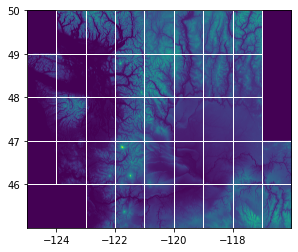

In [58]:
#with rio.open(vrt_fn) as src:
#ax = rio.plot.show(src)
#This doesn't work with axes returned by rio.plot.show, should be simple fix
#grid[idx].plot(ax=ax, edgecolor='w', facecolor='none');
f, ax = plt.subplots()
ax.imshow(src.read(1, masked=True), extent=rio.plot.plotting_extent(src))
grid[idx].plot(ax=ax, edgecolor='w', facecolor='none');

## Read with rioxarray
* Lazy

In [35]:
import rioxarray

In [36]:
xds = rioxarray.open_rasterio(vrt_fn, masked=True)

In [37]:
xds

<xarray.DataArray (band: 1, y: 6000, x: 10800)>
[64800000 values with dtype=float64]
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 50.0 50.0 50.0 50.0 50.0 ... 45.0 45.0 45.0 45.0
  * x            (x) float64 -125.0 -125.0 -125.0 ... -116.0 -116.0 -116.0
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

In [38]:
xds.spatial_ref

<xarray.DataArray 'spatial_ref' ()>
array(0)
Coordinates:
    spatial_ref  int64 0
Attributes:
    crs_wkt:                      GEOGCRS["WGS 84",DATUM["World Geodetic Syst...
    semi_major_axis:              6378137.0
    semi_minor_axis:              6356752.314245179
    inverse_flattening:           298.257223563
    reference_ellipsoid_name:     WGS 84
    longitude_of_prime_meridian:  0.0
    prime_meridian_name:          Greenwich
    geographic_crs_name:          WGS 84
    grid_mapping_name:            latitude_longitude
    spatial_ref:                  GEOGCRS["WGS 84",DATUM["World Geodetic Syst...
    GeoTransform:                 -125.00041666666667 0.0008333333333333326 0...

## Get 3DEP tiles

In [65]:
#Current url for 1/9th arcsec 3DEP raster products
url1='https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/19/IMG/ned19_n48x25_w122x50_wa_puget_sound_2000.zip'
fn1='ned19_n48x25_w122x50_wa_puget_sound_2000.img'
#Going to fetch and read zipfile on the fly, specifying img inside
path=f'/vsizip//vsicurl/{url1}/{fn1}'

In [60]:
#GUI based search for tiles
#https://prd-tnm.s3.amazonaws.com/LidarExplorer/index.html
#Contains public url for each zipfile
url_fn_3DEP = 'whidbey_USGS_19arcsec_3m.txt'

In [61]:
with open(url_fn_3DEP) as f:
    url_list = f.read().splitlines()

In [62]:
url_list

['https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/19/IMG/ned19_n48x25_w122x50_wa_puget_sound_2000.zip',
 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/19/IMG/ned19_n48x50_w122x50_wa_puget_sound_2000.zip',
 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/19/IMG/ned19_n48x00_w122x75_wa_puget_sound_2000.zip',
 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/19/IMG/ned19_n48x25_w122x75_wa_puget_sound_2000.zip',
 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/19/IMG/ned19_n48x50_w122x75_wa_puget_sound_2000.zip',
 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/19/IMG/ned19_n48x00_w122x50_wa_puget_sound_2000.zip',
 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/19/IMG/ned19_n48x50_w123x00_wa_sanjuanco_2009.zip',
 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/19/IMG/ned19_n48x50_w123x00_wa_puget_sound_2000.zip',
 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/19/IMG/ned19_n48x50_w122x75_wa

In [63]:
os.path.splitext(os.path.split(url_list[0])[-1])[0]+'.img'

'ned19_n48x25_w122x50_wa_puget_sound_2000.img'

In [64]:
path_list = []
for url in url_list:
    fn = os.path.splitext(os.path.split(url)[-1])[0]+'.img'
    path = f'/vsizip//vsicurl/{url}/{fn}'
    path_list.append(path)
path_list_str = ' '.join(path_list)

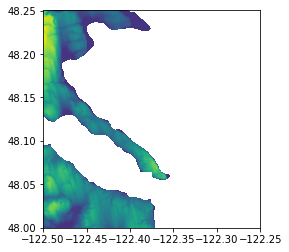

In [21]:
with rio.open(path) as src:
    rio.plot.show(src)

In [23]:
vrt_fn = os.path.splitext(url_fn_3DEP)[0]+'.vrt'
tif_fn = os.path.splitext(url_fn_3DEP)[0]+'.tif'
hs_fn = os.path.splitext(tif_fn)[0]+'_hs.tif'

In [117]:
#This actually takes some time as file must be downloaded and unzipped to read img header
!gdalbuildvrt $vrt_fn $path_list_str

0...10...20...30...40...50...60...70...80...90...100 - done.


In [20]:
#Since these tiles are in EPSG:4326 can download, reproject and mosaic in one go
!gdalwarp -r cubic -tr 3.0 3.0 -dstnodata -9999 -t_srs $dst_crs \
-co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER \
$path_list_str $tif_fn

Copying raster attribute table from /vsizip//vsicurl/https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/19/IMG/ned19_n48x25_w122x50_wa_puget_sound_2000.zip/ned19_n48x25_w122x50_wa_puget_sound_2000.img to new file.
Creating output file that is 19296P x 28706L.
Processing /vsizip//vsicurl/https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/19/IMG/ned19_n48x25_w122x50_wa_puget_sound_2000.zip/ned19_n48x25_w122x50_wa_puget_sound_2000.img [1/12] : 0Using internal nodata values (e.g. -3.40282e+38) for image /vsizip//vsicurl/https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/19/IMG/ned19_n48x25_w122x50_wa_puget_sound_2000.zip/ned19_n48x25_w122x50_wa_puget_sound_2000.img.
Copying nodata values from source /vsizip//vsicurl/https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/19/IMG/ned19_n48x25_w122x50_wa_puget_sound_2000.zip/ned19_n48x25_w122x50_wa_puget_sound_2000.img to destination whidbey_USGS_19arcsec_3m.tif.
...10...20...30...40...50...60...70...80...90...100 - don

In [24]:
!gdaldem hillshade -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER $tif_fn $hs_fn

0...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
!gdaladdo -r gauss $hs_fn

In [119]:
vrt_ds = rio.open(vrt_fn)

In [120]:
vrt_ds.profile

{'driver': 'VRT', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 24312, 'height': 24312, 'count': 1, 'crs': CRS.from_epsg(4269), 'transform': Affine(3.0864197530864944e-05, 0.0, -123.00018518518522,
       0.0, -3.086419753086406e-05, 48.500185185185195), 'blockxsize': 128, 'blockysize': 128, 'tiled': True}

## Zenodo dynamic read

In [13]:
test_fn='/vsicurl_streaming/https://zenodo.org/record/4558692/files/Chamoli_Feb2021_Composite_DEM2m_order_PHR_wmean.tif'

In [14]:
src = rio.open(test_fn)

In [17]:
a = src.read(1, masked=True)

In [18]:
a.shape

(12991, 15261)

In [20]:
a.size * 4 /1E9

0.793022604